<a href="https://colab.research.google.com/github/daemon-Lee/simplex_method_for_linear_program/blob/master/project/integer_programming/Branch_and_Bound.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Copyright 2020 Duy L.Dinh. { display-mode: "form" }
#@markdown CS1302 HE130655.
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at

#     http://www.apache.org/licenses/LICENSE-2.0

# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Branch and Bound

In [2]:
!pip install cplex

## Implement cplex lib

In [3]:
import cplex
import numpy as np
def cplex_lib(A, b, c):
    # Input all the data and parameters here
    num_constraints = len(A)
    num_decision_var = len(c) # - num_constraints
    
    n = np.arange(0, num_decision_var)[np.newaxis].T

    A = A[:,n.T].reshape(num_constraints, num_decision_var).tolist()
    b = b.tolist()
    c = c[n].T.reshape(len(n)).tolist()

    # constraint_type = ["L", "G", "E"] # Less, Greater, Equal
    constraint_type = ["L"]*num_constraints
    # ============================================================

    # Establish the Linear Programming Model
    myProblem = cplex.Cplex()

    # Add the decision variables and set their lower bound and upper bound (if necessary)
    myProblem.variables.add(names= ["x"+str(i) for i in range(num_decision_var)])
    for i in range(num_decision_var):
        myProblem.variables.set_lower_bounds("x"+str(i), 0.0)

    # Add constraints
    for i in range(num_constraints):
        myProblem.linear_constraints.add(
            lin_expr= [cplex.SparsePair(ind= [j for j in range(num_decision_var)], val= A[i])],
            rhs= [b[i]],
            names = ["c"+str(i)],
            senses = [constraint_type[i]]
        )

    # Add objective function and set its sense
    for i in range(num_decision_var):
        myProblem.objective.set_linear([(i, c[i])])
    myProblem.objective.set_sense(myProblem.objective.sense.maximize)

    # Solve the model and print the answer
    myProblem.solve()

    status = myProblem.solution.get_status_string()
    objective = 0
    sol = [0]*num_decision_var

    if status != 'infeasible':
        objective = myProblem.solution.get_objective_value()
        sol = myProblem.solution.get_values()

    return{
        'objective': objective,
        'status': status,
        'sol': sol
    }

## Define Branch and Bound pipeline

In [4]:
def add_key(dct1, dct2):
    """
        join two dictionary
    """
    for obj in dct2:
        dct1[obj] = dct2[obj] 
    return dct1

def branch_and_bound(A, b, c, depht = 5):
    """
        solve branch and bound using recursive
    """
    int_optimal = {}

    if depht == 0:
        print("stop")
        return int_optimal
    else:
        depht -= 1

    solution = cplex_lib(A, b, c)
    # print('here start')
    status = solution['status']
    
    if status.lower() == 'infeasible':
        print('here infeasible')
        return int_optimal        

    # check int for variables
    is_int = False
    vars = solution['sol']
    print("here sol", vars)
    is_int = np.array([var == int(var) for var in vars])

    if all(is_int):
        int_optimal[solution['objective']] = solution['sol']
        print(solution['objective'])
    else:
        not_int = np.where(~is_int)[0][0]
        floor = np.floor(vars[not_int])
        ceil = np.ceil(vars[not_int])
        
        # search left
        left = b.copy()
        ## update lower bound
        left[-2*len(c) + not_int] = floor
        print("enter left:", left)
        int_optimal = add_key(int_optimal, branch_and_bound(A, left, c, depht))

        # search right
        right = b.copy()
        ## update uppper bound
        right[-len(c) + not_int] = -ceil
        print("enter right:", right)
        int_optimal = add_key(int_optimal, branch_and_bound(A, right, c, depht))

    return int_optimal

def integer_solutions(A, b, c):
    """
        integer_solutions: get max optimal value with integer variables
    """
    int_optimal = branch_and_bound(A, b, c, depht=5)
    try:
        max_optimal = max(int_optimal.keys())
        return {"int_optimal":max_optimal,
                "vars":int_optimal[max_optimal]}
    except:
        return {"int_optimal":'NA',
                "vars":'NA'}

## Example to solve Integer programming

In [5]:
# A will contain the coefficients of the constraints
A = np.array([[ 2, 4],
              [ 1,  0],
              [ 0,  1],
              [-1,  0],
              [ 0, -1]])

# b will contain the amount of resources
b = np.array([25, 8, 5, 0, 0])

# c will contain coefficients of objective function Z
c = np.array([3,5])

In [6]:
integer_solutions(A, b, c)

Version identifier: 12.10.0.0 | 2019-11-27 | 843d4de
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
LP Presolve eliminated 4 rows and 0 columns.
Reduced LP has 1 rows, 2 columns, and 2 nonzeros.
Presolve time = 0.00 sec. (0.00 ticks)

Iteration log . . .
Iteration:     1   Dual objective     =            35.250000
here sol [8.0, 2.25]
enter left: [25  8  2  0  0]
Version identifier: 12.10.0.0 | 2019-11-27 | 843d4de
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
LP Presolve eliminated 5 rows and 2 columns.
All rows and columns eliminated.
Presolve time = 0.00 sec. (0.00 ticks)
here sol [8.0, 2.0]
34.0
enter right: [25  8  5  0 -3]
Version identifier: 12.10.0.0 | 2019-11-27 | 843d4de
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
LP Presolve eliminated 5 rows and 2 columns.
All rows and columns eliminated.
Presolve time = 0.00 sec. (0.00 ticks)
here sol [6.5, 3.0]
enter left: [25  6  5  0 -3]
Version i

{'int_optimal': 34.0, 'vars': [8.0, 2.0]}

# Solve by cplex tool

In [7]:
import cplex
import numpy as np
def cplex_int_lib(A, b, c):
    # Input all the data and parameters here
    num_constraints = len(A)
    num_decision_var = len(c) # - num_constraints
    
    n = np.arange(0, num_decision_var)[np.newaxis].T

    A = A[:,n.T].reshape(num_constraints, num_decision_var).tolist()
    b = b.tolist()
    c = c[n].T.reshape(len(n)).tolist()

    # constraint_type = ["L", "G", "E"] # Less, Greater, Equal
    constraint_type = ["L"]*num_constraints
    # ============================================================

    # Establish the Linear Programming Model
    myProblem = cplex.Cplex()

    # Add the decision variables and set their lower bound and upper bound (if necessary)
    myProblem.variables.add(names= ["x"+str(i) for i in range(num_decision_var)],
                            types = [myProblem.variables.type.integer for i in range(num_decision_var)])
    for i in range(num_decision_var):
        myProblem.variables.set_lower_bounds("x"+str(i), 0.0)

    # Add constraints
    for i in range(num_constraints):
        myProblem.linear_constraints.add(
            lin_expr= [cplex.SparsePair(ind= [j for j in range(num_decision_var)], val= A[i])],
            rhs= [b[i]],
            names = ["c"+str(i)],
            senses = [constraint_type[i]]
        )

    # Add objective function and set its sense
    for i in range(num_decision_var):
        myProblem.objective.set_linear([(i, c[i])])
    myProblem.objective.set_sense(myProblem.objective.sense.maximize)

    # Solve the model and print the answer
    myProblem.solve()

    status = myProblem.solution.get_status_string()
    objective = 0
    sol = [0]*num_decision_var
    print(status)
    if status != 'integer infeasible':
        objective = myProblem.solution.get_objective_value()
        sol = myProblem.solution.get_values()

    return{
        'objective': objective,
        'status': status,
        'sol': sol
    }

Problem example:

$Maximize:\quad 3\times x_{1} + 5\times x_{2}
\\Subject: \qquad 2\times x_{1} + 4\times x_{2} \: \leqslant 25
\\ \qquad \quad \quad \qquad \qquad x_{1} \qquad \qquad \leqslant 8
\\ \qquad \quad \quad \qquad \qquad \qquad \qquad x_{2} \leqslant 5
\\ \qquad \quad \quad \qquad \qquad x_{1} \qquad \qquad \geqslant 0
\\ \qquad \quad \quad \qquad \qquad \qquad \qquad x_{2} \geqslant 0$

In [8]:
# A will contain the coefficients of the constraints
A = np.array([[ 2,  4],
              [ 1,  0],
              [ 0,  1],
              [-1,  0],
              [ 0, -1]])

# b will contain the amount of resources
b = np.array([25, 8, 5, 0, 0])

# c will contain coefficients of objective function Z
c = np.array([3,5])

In [9]:
cplex_int_lib(A, b, c)

Version identifier: 12.10.0.0 | 2019-11-27 | 843d4de
CPXPARAM_Read_DataCheck                          1
Found incumbent of value 0.000000 after 0.00 sec. (0.00 ticks)
Tried aggregator 1 time.
MIP Presolve eliminated 5 rows and 0 columns.
MIP Presolve added 1 rows and 1 columns.
MIP Presolve modified 2 coefficients.
Reduced MIP has 1 rows, 3 columns, and 3 nonzeros.
Reduced MIP has 0 binaries, 3 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.00 ticks)
Tried aggregator 1 time.
MIP Presolve eliminated 1 rows and 1 columns.
MIP Presolve added 1 rows and 1 columns.
Reduced MIP has 1 rows, 3 columns, and 3 nonzeros.
Reduced MIP has 0 binaries, 3 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.00 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 2 threads.
Root relaxation solution time = 0.00 sec. (0.00 ticks)

        Nodes                                         Cuts/
   No

{'objective': 34.0, 'sol': [8.0, 2.0], 'status': 'integer optimal solution'}

# Benmark

## Generate problem to compare

In [10]:
def gen_int_problem(n_var, n_contrain):

    contrain = np.random.randint(low=-7, high=19, size=(n_var,n_contrain))
    lower = np.eye(n_var)
    upper = -lower

    # A will contain the coefficients of the constraints 
    A = contrain.T
    A = np.concatenate((A,lower), axis=0)
    A = np.concatenate((A,upper), axis=0)

    # b will contain the amount of resources 
    b = np.random.randint(low=-7, high=19, size=(n_contrain,))
    uc = np.random.randint(low=0, high=19, size=(n_var,))
    lc = np.zeros((n_var,))
    b = np.concatenate([b,uc])
    b = np.concatenate([b,lc])

    # c will contain coefficients of objective function Z
    c = np.random.randint(low=-7, high=19, size=(n_var,))

    return A, b, c

In [11]:
A, b, c = gen_int_problem(2, 1)

In [12]:
#@title Set number of sample
n_sample =  100#@param {type:"integer"}

In [13]:
np.random.seed(2020)
A_list = []
b_list = []
c_list = []
for i in range(n_sample):
    n_var = np.random.randint(low=2, high=7)
    n_contrain = np.random.randint(low=2, high=7)
    A, b, c = gen_int_problem(n_var, n_contrain)
    A_list.append(A)
    b_list.append(b)
    c_list.append(c)

In [14]:
from time import time

In [15]:
%%capture
running_time_code = []
output_code = []
for i in range(n_sample):
    start = time()
    output_code.append(integer_solutions(A, b, c))
    end = time() - start
    running_time_code.append(end)

In [16]:
%%capture
running_time_cplex = []
output_cplex = []
for i in range(n_sample):
    start = time()
    output_cplex.append(cplex_int_lib(A, b, c))
    end = time() - start
    running_time_cplex.append(end)

In [17]:
# code
mean_code = np.mean(running_time_code)
std_code = np.std(running_time_code)

# cplex
mean_cplex = np.mean(running_time_cplex)
std_cplex = np.std(running_time_cplex)

## visualization benmark compare

In [18]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[Text(0.5, 0, 'code'), Text(1.5, 0, 'cplex')]

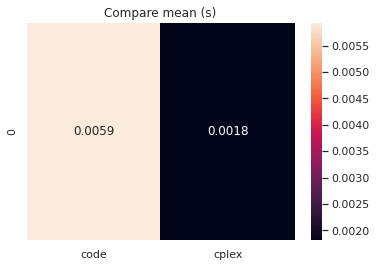

In [19]:
mean = np.array([mean_code, mean_cplex])[np.newaxis]
ax = sns.heatmap(mean, annot=True)
plt.title("Compare mean (s)")
ax.set_xticklabels(['code','cplex'])